* Using Spacy (basic nlp model)
* DL learning training
* Using pretrained DL models

# **Using Spacy**

- PERSON — People, including fictional.
- NORP — Nationalities, religious or political groups.
- FAC — Buildings, airports, highways, bridges, etc.
- ORG — Companies, agencies, institutions, organizations.
- GPE — Countries, cities, states.
- LOC — Non-GPE locations, mountain ranges, bodies of water.
- PRODUCT — Objects, vehicles, foods, etc. (not services).
- EVENT — Named hurricanes, battles, wars, sports events, etc.
- WORK_OF_ART — Titles of books, songs, artworks, etc.
- LAW — Named documents made into laws.
- LANGUAGE — Any named language.
- DATE — Absolute or relative dates or periods.
- TIME — Times smaller than a day.
- PERCENT — Percentage values, including "%".
- MONEY — Monetary values, including unit.
- QUANTITY — Measurements like weight or distance.
- ORDINAL — "first", "second", etc.
- CARDINAL — Numerals that do not fall under another type.


In [ ]:
import pandas as pd
import spacy

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
# extracting entities from the text

content = "Trinamool Congress leader Mahua Moitra has moved the Supreme Court against her expulsion from the Lok Sabha over the cash-for-query allegations against her. Moitra was ousted from the Parliament last week after the Ethics Committee of the Lok Sabha found her guilty of jeopardising national security by sharing her parliamentary portal's login credentials with businessman Darshan Hiranandani."

doc = nlp(content)
print(type(doc))
for ent in doc.ents:
  print(f"{ent.text} | {ent.start_char} | {ent.end_char} | {ent.label_}")

<class 'spacy.tokens.doc.Doc'>
Trinamool Congress | 0 | 18 | ORG
Mahua Moitra | 26 | 38 | PERSON
the Supreme Court | 49 | 66 | ORG
Moitra | 157 | 163 | NORP
Parliament | 184 | 194 | ORG
last week | 195 | 204 | DATE
the Ethics Committee | 211 | 231 | ORG
Darshan Hiranandani | 373 | 392 | PERSON


In [ ]:
# visualizing the display

from spacy import displacy
displacy.render(doc, style='ent')

In [ ]:
# dataframe view with the root words

entities = [(ent.text, ent.label_, ent.lemma_) for ent in doc.ents]
df = pd.DataFrame(entities, columns=['text', 'type', 'lemma'])
df.head()

,text,type,lemma
0,Trinamool Congress,ORG,Trinamool Congress
1,Mahua Moitra,PERSON,Mahua Moitra
2,the Supreme Court,ORG,the Supreme Court
3,Moitra,NORP,Moitra
4,Parliament,ORG,Parliament


# **Training a DL model**

Using BiLSTM + CRF

In [ ]:
# importing libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import Model, Input
from keras.layers import LSTM, Embedding, Dense
from keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

from itertools import chain

In [ ]:
# reading the data

data = pd.read_csv('/content/ner_datasetreference.csv', encoding='unicode_escape')
data.head()


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048565 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [ ]:
# we dont nedd POS column
data.drop('POS', axis=1, inplace=True)

In [ ]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O


In [ ]:
# filling the nan values
data = data.fillna(method='ffill')

/tmp/ipython-input-2603495661.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [ ]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [ ]:
# vocabulory
words = list(set(data['Word'].values))

#appending the end word
words.append('ENDPAD')

print("Vocabulory size:", len(words))
print(words[-1])

Vocabulory size: 35178
ENDPAD


In [ ]:
# total words

num_words = len(data['Word'])
print(f"Total number of words: {num_words}")

Total number of words: 1048575


In [ ]:
# list of tags

tags = list(set(data['Tag'].values))
num_tags = len(tags)
print(f"Total number of tags: {num_tags}")
print(f"List of tags: {', '.join([tag for tag in tags])}")

Total number of tags: 17
List of tags: I-art, B-eve, B-org, B-tim, I-tim, I-geo, I-org, O, I-eve, B-art, B-gpe, B-nat, I-per, B-geo, I-gpe, I-nat, B-per


In [ ]:
# class for sentense and tags mapping

class Get_sentense(object):
  def __init__(self, data):
    self.n_sent = 1
    self.data = data

    agg_func = lambda s: [(w, t) for w, t in zip(s['Word'].tolist(), s['Tag'].tolist())]
    self.grouped = self.data.groupby('Sentence #').apply(agg_func)
    self.sentenses = [s for s in self.grouped]

In [ ]:
getter = Get_sentense(data)
sentence = getter.sentenses

/tmp/ipython-input-2417060189.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby('Sentence #').apply(agg_func)


In [ ]:
print(type(sentence))
print(f"Number of sentences: {len(sentence)}")

<class 'list'>
Number of sentences: 47959


In [ ]:
sentence[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

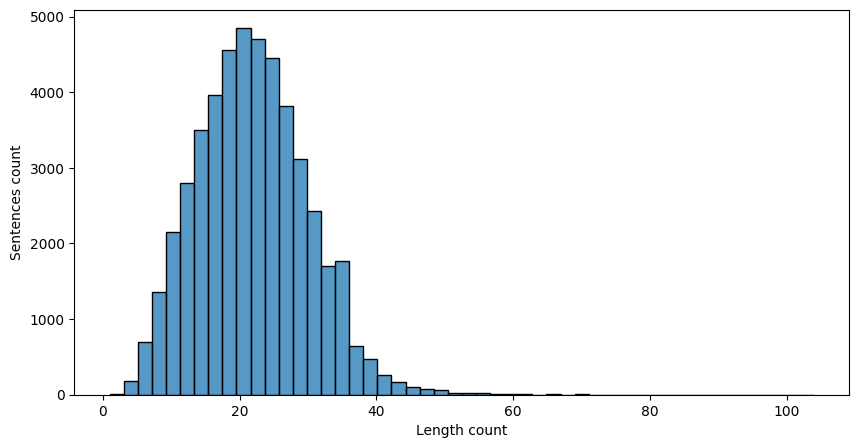

In [ ]:
# Data visualization
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in sentence], bins=50)
plt.xlabel('Length count')
plt.ylabel('Sentences count')
plt.show()

In [ ]:
# data preparation

word_idx = {w: i+1 for i, w in enumerate(words)}
tag_idx = {t: i for i, t in enumerate(tags)}

len(tag_idx)

17

In [ ]:
word_idx['PAD'] = 0

In [ ]:
max_len=50
padding_value = word_idx['PAD']
X=[[word_idx[w[0]] for w in s] for s in sentence]
X=pad_sequences(maxlen=max_len,sequences=X,padding='post',value=padding_value)
y=[[tag_idx[w[1]]for w in s]for s in sentence]
y=pad_sequences(maxlen=max_len,sequences=y,padding='post',value=tag_idx['O'])

In [ ]:
print(len(X))
print(len(y))

print(len(X[0]))
print(len(y[0]))

47959
47959
50
50


In [ ]:
X[0]

array([24289, 21774,  2438, 16923,  7947, 26307, 29807, 12427,  6285,
       26106, 11052, 15296,  3145, 25631, 11371, 26106, 32089, 21774,
       17065, 26306, 24005,  8608, 25463, 29552,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [ ]:
y[0]

array([ 7,  7,  7,  7,  7,  7, 13,  7,  7,  7,  7,  7, 13,  7,  7,  7,  7,
        7, 10,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
      dtype=int32)

In [ ]:
# numerical to one-hot encoding vectors

y = [to_categorical(i, num_classes=num_tags) for i in y]

In [ ]:
y[0]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0

In [ ]:
# train test splitting

X_train, X_test, y_trian, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# BiLSTM building

input_word = Input(shape=(max_len, ))
model = Embedding(input_dim=num_words, output_dim=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)

model = Model(input_word, out)


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 50)         │    52,428,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 50, 50)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 200)        │       120,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 17)         │         3,417 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,552,967 (200.47 MB)

 Trainable params: 52,552,967 (200.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# training

model.fit(
    X_train, np.array(y_trian),
    batch_size=64,
    epochs = 3,
    validation_split=0.2
)

Epoch 1/3
540/540 ━━━━━━━━━━━━━━━━━━━━ 548s 991ms/step - accuracy: 0.9284 - loss: 0.4101 - val_accuracy: 0.9750 - val_loss: 0.0907
Epoch 2/3
540/540 ━━━━━━━━━━━━━━━━━━━━ 518s 913ms/step - accuracy: 0.9799 - loss: 0.0723 - val_accuracy: 0.9833 - val_loss: 0.0571
Epoch 3/3
540/540 ━━━━━━━━━━━━━━━━━━━━ 519s 962ms/step - accuracy: 0.9865 - loss: 0.0453 - val_accuracy: 0.9845 - val_loss: 0.0510


In [ ]:
# evaluation

model.evaluate(X_test, np.array(y_test))

150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9844 - loss: 0.0510


[0.05100823938846588, 0.9843330383300781]

In [ ]:
# prediction

rand_sent = np.random.randint(0, X_test.shape[0])
print('random sentense index: ', rand_sent)
p = model.predict(np.array([X_test[rand_sent]]))
p = np.argmax(p, axis = -1)
print(p[0])

y_true=np.argmax(np.array(y_test),axis=-1)[rand_sent]

print("{:20}{:20}\t{}\n".format("Word","True","Pred"))
print("-"*55)

for (w,t,pred)in zip(X_test[rand_sent],y_true,p[0]):
    print("{:20}{:20}\t{}".format(words[w-1],tags[t],tags[pred]))

random sentense index:  1596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[ 7  2  7  7  7  7  7  7  7  7  7  7  2 10  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7]
Word                True                	Pred

-------------------------------------------------------
A                   O                   	O
Marine              B-org               	B-org
patrol              I-org               	O
found               O                   	O
the                 O                   	O
unidentified        O                   	O
body                O                   	O
in                  O                   	O
a                   O                   	O
street              O                   	O
of                  O                   	O
the                 O                   	O
violence-torn       O                   	B-org
Iraqi               B-gpe               	B-gpe
city                O                   	O
.                  